Copyright **`(c)`** 2024 Giovanni Squillero `<giovanni.squillero@polito.it>`  
[`https://github.com/squillero/computational-intelligence`](https://github.com/squillero/computational-intelligence)  
Free for personal or classroom use; see [`LICENSE.md`](https://github.com/squillero/computational-intelligence/blob/master/LICENSE.md) for details.  

# Set Cover problem

See: https://en.wikipedia.org/wiki/Set_cover_problem

In [2]:
from random import random, seed
from itertools import product, accumulate
import numpy as np
from tqdm.auto import tqdm

from icecream import ic

from matplotlib import pyplot as plt

/Users/Frutto/.pyenv/versions/CI/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Reproducible Initialization

If you want to get reproducible results, use `rng` (and restart the kernel); for non-reproducible ones, use `np.random`.

In [41]:
# Possbile combinations of sets
# size: 100, sets: 10, density: .2
# size: 1000, sets: 100, density: .2
# size: 10000, sets: 1000, density: .2
# size: 100000, sets: 10000, density: .1
# size: 100000, sets: 10000, density: .2
# size: 100000, sets: 10000, density: .3

UNIVERSE_SIZE = 100000
NUM_SETS = 10000
DENSITY = 0.1

rng = np.random.Generator(np.random.PCG64([UNIVERSE_SIZE, NUM_SETS, int(10_000 * DENSITY)]))

In [42]:
# DON'T EDIT THESE LINES!

SETS = np.random.random((NUM_SETS, UNIVERSE_SIZE)) < DENSITY
for s in range(UNIVERSE_SIZE):
    if not np.any(SETS[:, s]):
        SETS[np.random.randint(NUM_SETS), s] = True
COSTS = np.pow(SETS.sum(axis=1), 1.1)

## Helper Functions

In [5]:
# def old_valid(solution):
#     """Checks wether solution is valid (ie. covers all universe)"""
#     return np.all(np.logical_or.reduce(SETS[solution]))


def valid(solution):
    """Checks wether solution is valid (ie. covers all universe)"""
    phenotype = np.logical_or.reduce(SETS[solution])
    return np.all(phenotype)


def cost(solution):
    """Returns the cost of a solution (to be minimized)"""
    return COSTS[solution].sum()

## Have Fun!

In [43]:
# A dumb solution of "all" sets
solution = np.full(NUM_SETS, True)
print(solution)
valid(solution), cost(solution)

[ True  True  True ...  True  True  True]


(np.True_, np.float64(251214604.8347006))

In [ ]:
# A random solution with random 50% of the sets
solution = rng.random(NUM_SETS) < .5
valid(solution), cost(solution)

# RMHC
## Defining the tweak functions

In [22]:
def single_mutation(solution: np.ndarray) -> np.ndarray:
    new_sol = solution.copy()
    i = rng.integers(0, NUM_SETS)
    new_sol[i] = not new_sol[i]
    return new_sol

def multiple_mutation(solution: np.ndarray) -> np.ndarray:
    new_sol = solution.copy()
    mask = rng.random(NUM_SETS) < .01
    return np.logical_xor(new_sol, mask)

## Defining the fitness function

In [11]:
def fitness(solution: np.ndarray) -> float:
    return -cost(solution)

In [ ]:
solution = rng.random(NUM_SETS) < .5

# Simplest Hill Climbing
for _ in range(100):
    new_solution = single_mutation(solution)
    if fitness(new_solution) > fitness(solution):
        solution = new_solution
        ic(fitness(solution))

ic(solution, fitness(solution))

# As we can see, the solution is not valid, since, having as the only parameter the cost (fitness), the algorithm will simply find the null solution (no sets selected -> cost = 0). We modify the fitness method

## Adapting the fitness function to the validity measure

In [12]:
def fitness(solution: np.ndarray) -> float:
    return (valid(solution), -cost(solution))

In [ ]:
solution = rng.random(NUM_SETS) < .5

for _ in range(100):
    new_solution = single_mutation(solution)
    if fitness(new_solution) > fitness(solution):
        solution = new_solution
        ic(fitness(solution))

ic(solution, fitness(solution))

# The solution is still wrong, since, for the solution to become valid, we need to add some sets, which will increase the cost. We need to modify the tweak method to add sets instead of removing them

In [ ]:
solution = rng.random(NUM_SETS) < 1
steps = 10000

for _ in range(steps):
    new_solution = single_mutation(solution)
    if fitness(new_solution) > fitness(solution):
        solution = new_solution
        ic(fitness(solution))

ic(solution, fitness(solution))

# Starting from a full solution, we can see that the algorithm is able to find a valid solution with a decreasing cost.
# The more steps we run, the better the solution will be.

## Visualizing the cost over time

In [44]:
solution = rng.random(NUM_SETS) < .5
steps = 10000

solution_fitness = fitness(solution)
history = [solution_fitness[1]]

for _ in range(steps):
    new_solution = single_mutation(solution)
    f = fitness(new_solution)
    history.append(f[1])

    if f > solution_fitness:
        solution = new_solution
        solution_fitness = fitness(solution)
        ic(fitness(solution))

ic(solution, fitness(solution))

plt.figure(figsize=(14, 8))
plt.plot(range(len(history)), list(accumulate(history, max)), color='red')
_ = plt.scatter(range(len(history)), history, marker='.')

ic| fitness(solution): (np.True_, np.float64(-124533939.60604078))
ic| fitness(solution): (np.True_, np.float64(-124508947.81390536))
ic| fitness(solution): (np.True_, np.float64(-124483652.05630602))
ic| fitness(solution): (np.True_, np.float64(-124458754.14936548))
ic| fitness(solution): (np.True_, np.float64(-124433618.70610267))
ic| fitness(solution): (np.True_, np.float64(-124408295.2987464))
ic| fitness(solution): (np.True_, np.float64(-124382861.26493892))
ic| fitness(solution): (np.True_, np.float64(-124357330.39708395))
ic| fitness(solution): (np.True_, np.float64(-124332203.2434193))
ic| fitness(solution): (np.True_, np.float64(-124306918.54495364))
ic| fitness(solution): (np.True_, np.float64(-124281509.40591861))
ic| fitness(solution): (np.True_, np.float64(-124255637.97130086))
ic| fitness(solution): (np.True_, np.float64(-124230297.97277279))
ic| fitness(solution): (np.True_, np.float64(-124205339.32025602))
ic| fitness(solution): (np.True_, np.float64(-124180151.37043591

KeyboardInterrupt: 

## More mutations

In [ ]:
solution = rng.random(NUM_SETS) < .5
steps = 10000

solution_fitness = fitness(solution)
history = [solution_fitness[1]]

for _ in range(steps):
    new_solution = multiple_mutation(solution)
    f = fitness(new_solution)
    history.append(f[1])

    if f > solution_fitness:
        solution = new_solution
        solution_fitness = fitness(solution)
        ic(fitness(solution))

ic(solution, fitness(solution))

plt.figure(figsize=(14, 8))
plt.plot(range(len(history)), list(accumulate(history, max)), color='red')
_ = plt.scatter(range(len(history)), history, marker='.')

# Steepest step and restart

step 1: 100%|██████████| 1333/1333 [16:48<00:00,  1.32it/s]
ic| fitness(solution): (np.True_, np.float64(-92859759.1754941))
step 2: 100%|██████████| 1333/1333 [22:40<00:00,  1.02s/it]
ic| fitness(solution): (np.True_, np.float64(-92029639.54433468))
step 3: 100%|██████████| 1333/1333 [1:20:25<00:00,  3.62s/it]
ic| fitness(solution): (np.True_, np.float64(-93008953.85104492))
100%|██████████| 3/3 [1:59:56<00:00, 2398.68s/it]
ic| fitness(best_solution): (np.True_, np.float64(-92029639.54433468))
ic| history.index(fitness(best_solution)[1]): 13328


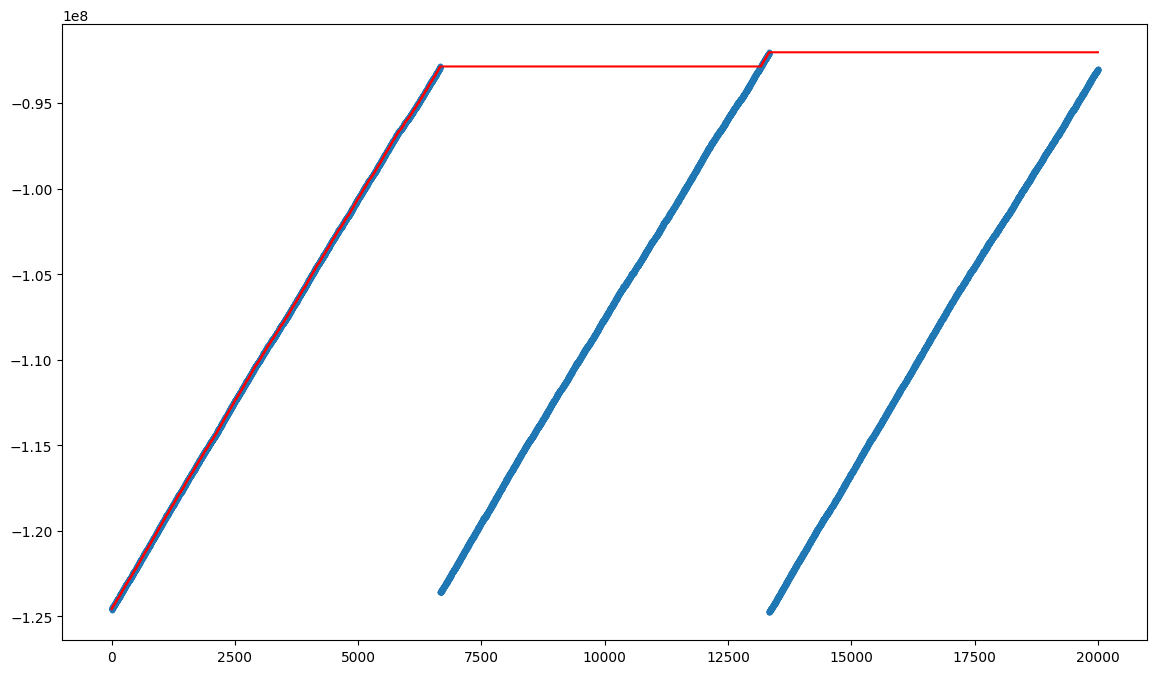

In [45]:
NUM_RESTARTS = 3
STEEPEST_STEP_CANDIDATES = 5
MAX_STEPS = 20000
TRUE_MAX_STEPS = MAX_STEPS // STEEPEST_STEP_CANDIDATES

max_value = (0, -1)
num_steps = 0
history = list()

for i in tqdm(range(NUM_RESTARTS), position=0):
    solution = rng.random(NUM_SETS) < .5
    history.append(fitness(solution)[1])

    last_improvement = (0, 0)
    new_solution = solution

    for n in tqdm(range(TRUE_MAX_STEPS // NUM_RESTARTS), position=1, desc=f'step {i+1}'):
        # create candidate solutions and evaluate them
        candidates = [single_mutation(solution) for i in range(STEEPEST_STEP_CANDIDATES)]
        candidates_fitness = list()
        for c in candidates:
            f = fitness(c)
            history.append(f[1])
            candidates_fitness.append(f)
        idx = candidates_fitness.index(max(candidates_fitness))

        # keep candidate solution that yielded the steepest ascent
        new_solution = candidates[idx]
        new_fitness = candidates_fitness[idx]
        num_steps += STEEPEST_STEP_CANDIDATES

        if new_fitness > fitness(solution):
            solution = new_solution

    ic(fitness(solution))

    if fitness(solution) > max_value:
        max_value = fitness(solution)
        best_solution = solution

# That's all...
ic(fitness(best_solution))
ic(history.index(fitness(best_solution)[1]))

plt.figure(figsize=(14, 8))
plt.plot(
    range(len(history)),
    list(accumulate(history, max)),
    color="red",
)
_ = plt.scatter(range(len(history)), history, marker=".")